# Differentiable bitonic sort

[Bitonic sorts](https://en.wikipedia.org/wiki/Bitonic_sorter) allow creation of sorting networks with a sequence of fixed conditional swapping operations executed in parallel. A sorting network implements  a map from $\mathbb{R}^n \rightarrow \mathbb{R}^n$, where $n=2^k$ (sorting networks for non-power-of-2 sizes are possible but not trickier).

<img src="BitonicSort1.svg.png">

*[Image: from Wikipedia, by user Bitonic, CC0](https://en.wikipedia.org/wiki/Bitonic_sorter#/media/File:BitonicSort1.svg)*

The sorting network for $n=2^k$ elements has $\frac{k(k-1)}{2}$ "layers" where parallel compare-and-swap operations are used to rearrange a $k$ element vector into sorted order.

### Differentiable compare-and-swap

If we define the `softmax(a,b)` function (not the traditional "softmax" used for classification!) as the continuous approximation to the `max(a,b)` function:

$$\text{softmax}(a,b) = \log(e^a + e^b) \approx \max(a,b).$$

We can then fairly obviously write `softmin(a,b)` as:

$$\text{softmin}(a,b) = -\log(e^{-a} + e^{-b}) \approx \min(a,b).$$ More numerically stably we can write: 

$$\text{softmin}(a,b) = a + b - \text{softmax}(a,b).$$

These functions aren't equal to max and min, but are relatively close for numbers in some range, and differentiable. Note that we now have a differentiable compare-and-swap operation:

$$\text{softcswap}(a,b) = [\text{softmin}(a,b), \text{softmin}(a,b)]$$

#### Smoothmax
Alternatively, we can use: 
$$\text{smoothmax}(a,b) = \frac{a (e^{\alpha a}) + b (e^{\alpha b})}{e^{\alpha a}+e^{\alpha b}}  \approx \max(a,b).$$  This has an adjustable smoothness parameter $\alpha$, with exact maximum as $\alpha \rightarrow \infty$ and pure averaging as $\alpha \rightarrow 0$.

## Differentiable sorting

For each layer in the sorting network, we can split all of the pairwise comparison-and-swaps into left-hand and right-hand sides which can be done simultaneously. We can select the relevant elements of the vector as a multiply with a binary matrix.

For each layer, we can derive two binary matrices $L \in \mathbb{R}^{n \times \frac{n}{2}}$ and $R \in \mathbb{R}^{n \times \frac{n}{2}}$ which select the elements to be compared for the left and right hands respectively. This will result in the comparison between two $\frac{n}{2}$ length vectors. We can also derive two matrices $L' \in \mathbb{R}^{\frac{n}{2} \times n}$ and $R' \in \mathbb{R}^{\frac{n}{2} \times n}$ which put the results of the compare-and-swap operation back into the right positions.

Then, each layer $i$ of the sorting process is just:
$${\bf x}_{i+1} = L'_i[\text{softmin}(L_i{\bf x_i}, R_i{\bf x_i})] + R'_i[\text{softmax}(L_i{\bf x_i}, R_i{\bf x_i})]$$
$$ = L'_i\left(-\log\left(e^{-L_i{\bf x}_i} + e^{-R_i{\bf x}_i}\right)\right) +  R'_i\left(\log\left(e^{L_i{\bf x}_i} + e^{R_i{\bf x}_i}\right)\right)$$
which is differentiable (though not very numerically stable -- the usable range of elements $x$ is quite limited in single float precision).

All that remains is to compute the matrices $L_i, R_i, L'_i, R'_i$ for each of the layers of the network, which are fixed for a given $n$. 

## Example

To sort four elements, we have a network like:

    0  1  2  3  
    ┕>>┙  │  │  
    │  │  ┕<<┙  
    ┕>>>>>┙  │  
    │  │  │  │  
    ┕>>┙  │  │  
    │  │  ┕>>┙  
    
This is equivalent to: 

    x[0], x[1] = cswap(x[0], x[1])
    x[3], x[2] = cswap(x[2], x[3])
    x[0], x[2] = cswap(x[0], x[2])
    x[0], x[1] = cswap(x[0], x[1])
    x[2], x[3] = cswap(x[2], x[3])
    
where `cswap(a,b) = (min(a,b), max(a,b))`

Replacing the indexing with matrix multiplies and `cswap` with a `softcswap = (softmin(a,b), softmax(a,b))` we then have the differentiable form.



# Test functions

In [233]:
from bitonic_tests import bitonic_network, pretty_bitonic_network

def neat_vec(n):
    # print a vector neatly    
    return "\t".join([f"{x:6.2f}" for x in n])

# the comparisons should match the diagram at the top of the notebook
# each line represents one pair of matrix multiplies
bitonic_network(16)

 0>1	 2<3	 4>5	 6<7	 8>9	10<11	12>13	14<15	
----------------------------------------------------------------
 0>2	 1>3	 4<6	 5<7	 8>10	 9>11	12<14	13<15	
 0>1	 2>3	 4<5	 6<7	 8>9	10>11	12<13	14<15	
----------------------------------------------------------------
 0>4	 1>5	 2>6	 3>7	 8<12	 9<13	10<14	11<15	
 0>2	 1>3	 4>6	 5>7	 8<10	 9<11	12<14	13<15	
 0>1	 2>3	 4>5	 6>7	 8<9	10<11	12<13	14<15	
----------------------------------------------------------------
 0>8	 1>9	 2>10	 3>11	 4>12	 5>13	 6>14	 7>15	
 0>4	 1>5	 2>6	 3>7	 8>12	 9>13	10>14	11>15	
 0>2	 1>3	 4>6	 5>7	 8>10	 9>11	12>14	13>15	
 0>1	 2>3	 4>5	 6>7	 8>9	10>11	12>13	14>15	
----------------------------------------------------------------


In [236]:
pretty_bitonic_network(8)

 0  1  2  3  4  5  6  7 
 ╭──╯  │  │  │  │  │  │ 
 │  │  ╰──╮  │  │  │  │ 
 │  │  │  │  ╭──╯  │  │ 
 │  │  │  │  │  │  ╰──╮ 
 ╭─────╯  │  │  │  │  │ 
 │  ╭─────╯  │  │  │  │ 
 │  │  │  │  ╰─────╮  │ 
 │  │  │  │  │  ╰─────╮ 
 ╭──╯  │  │  │  │  │  │ 
 │  │  ╭──╯  │  │  │  │ 
 │  │  │  │  ╰──╮  │  │ 
 │  │  │  │  │  │  ╰──╮ 
 ╭───────────╯  │  │  │ 
 │  ╭───────────╯  │  │ 
 │  │  ╭───────────╯  │ 
 │  │  │  ╭───────────╯ 
 ╭─────╯  │  │  │  │  │ 
 │  ╭─────╯  │  │  │  │ 
 │  │  │  │  ╭─────╯  │ 
 │  │  │  │  │  ╭─────╯ 
 ╭──╯  │  │  │  │  │  │ 
 │  │  ╭──╯  │  │  │  │ 
 │  │  │  │  ╭──╯  │  │ 
 │  │  │  │  │  │  ╭──╯ 


# Vectorised functions

In [238]:
# Test sorting
import autograd.numpy as np # we can use plain numpy as well (but can't take grad!)
np.set_printoptions(precision=2)

from differentiable_sorting import bitonic_matrices, diff_sort, diff_argsort
from differentiable_sorting import softmax, smoothmax, softmax_smooth

## Testing sorting network
First, test bitonic sorting with exact (non-differentiable) maximum; this should work exactly as regular sorting does.

In [317]:
big_matrices = bitonic_matrices(1024)
print(len(big_matrices))
test = np.random.uniform(-350, 350, 1024)
sortd = diff_sort(big_matrices, test, softmax=lambda a,b:smoothmax(a,b,alpha=1))
true = np.sort(test)
for i,j in zip(sortd, true):
    print(i,j)


55
-348.4833641260541 -349.4411974535092
-348.480440404363 -348.68491701393947
-348.4339075303822 -348.57873070342544
-348.42476338304044 -348.15719059578356
-348.25094308838646 -347.9256753503746
-345.1098494227487 -345.9401848417681
-343.2135301132494 -343.22424955890926
-343.2034151222388 -343.1386387479124
-341.8040312470505 -342.92053849996086
-341.7992829710122 -342.56999704608944
-341.0248903154151 -341.2233435209284
-341.02168402305045 -340.57818083602405
-340.6376304883754 -340.43858668497444
-340.6376229677005 -340.40125758758376
-340.3484522740445 -340.2459531945731
-340.34843585704476 -340.1272369289023
-339.7039493375852 -339.4979045838633
-339.70393776426056 -338.70738680590904
-335.9973873375637 -336.5900974937231
-335.6309459753333 -335.7165727155334
-334.91903851998194 -334.6557756900909
-334.90578355734243 -334.64264457418693
-333.2315155024141 -333.0585722669363
-332.3393929818413 -332.2607598733368
-330.38038985553914 -330.78571264932845
-328.8518437677847 -329.3636

-222.7399122135735 -222.60449055169119
-222.2054176634019 -222.06808546545275
-221.12658176624046 -220.83653652608544
-219.23006880886402 -218.6827797935709
-218.96802113545604 -218.65287567892437
-213.85982523348324 -214.45814704062215
-213.69221033455932 -214.02303907552817
-213.67635758117427 -213.49804473640583
-213.58674618051805 -213.22951545190384
-211.04225867248113 -211.5027183494692
-209.43816652371234 -209.74234950496137
-209.13363224363346 -209.20067059723556
-207.31785751474237 -207.704449614295
-206.9051022883268 -207.16772621882362
-205.87848781787292 -206.4221262719977
-205.51081735111123 -205.62523300252153
-203.60980138414513 -203.8996307501893
-203.56241957599784 -203.75375818944877
-203.39292394800682 -203.7249248697295
-203.3869886347288 -203.71538597493844
-203.39019828195558 -203.5938706170839
-203.3836810539931 -203.56367145881316
-203.06221251605623 -203.44878063119904
-203.0619542534267 -203.36247313795585
-203.018250572243 -202.628840794577
-203.0146619482333

-74.05148990783685 -74.2877513045218
-72.08587034021411 -72.20920095309668
-71.84527802188327 -72.04120591014578
-71.71454131861287 -71.8876895485422
-71.6320449111303 -71.54548945948562
-70.35296434480414 -71.10975945860145
-70.32099087243343 -70.167446117981
-69.46034941374809 -69.29203824923428
-68.55566389015551 -68.77400929098559
-67.88690256759011 -67.52197542547691
-67.5124256496932 -67.26069536264151
-67.41349772574387 -66.79574342958983
-67.36512583153245 -66.40653250879888
-62.97171853495332 -64.76365635744673
-62.90429496653086 -63.07368190486915
-62.86891514123988 -62.53517183750154
-62.82152274022934 -62.45219663290919
-62.33535796653773 -61.3192618400609
-59.55994065206606 -60.28403965947422
-58.343843514454505 -58.818452165586905
-58.30549372888808 -58.61610784855645
-57.66478359298371 -57.71921218808569
-57.27908024399001 -57.52964697799257
-56.591957357053076 -56.807594808527426
-56.5721400552855 -56.43196234430371
-55.79638799335563 -55.687497723158515
-55.73978287672

79.95198750156617 80.48450752463452
80.00562036851484 80.88160991163471
80.88267520221643 81.07202231344536
80.95473000061014 81.29000952576638
81.23240394571259 81.36308360487487
81.25292947042134 81.70471233730649
82.0057349995685 82.00482345798775
82.00808534556354 82.61080285041851
82.21063243496286 83.06321846169334
83.74060790694574 84.59490191921606
84.70978601123446 85.43747442236162
88.60555934499618 87.95216235232243
89.50084182692173 88.78309038277308
89.50507082721627 90.30424812131736
90.26963656106082 90.64636571139238
91.54622003291217 91.75972609845553
95.54874696640415 95.07077400514532
95.55160734784347 95.53755358694713
95.836745497486 95.55869891960401
95.84239893730135 96.03940567322178
98.30588097887383 97.86601092988047
98.33739195447689 98.52264593461308
99.7477324922441 99.7624233652707
99.77994970685563 100.25849726227005
102.390376933 102.45312873913917
104.00852015392505 103.78735114435904
104.44359276936086 104.29304301990459
106.95925941179487 106.66008685

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [239]:


matrices = bitonic_matrices(8)

for i in range(5):
    # these should all be in sorted order
    test = np.random.randint(0, 200, 8)
    sortd = diff_sort(matrices, test, softmax=np.maximum)
    assert(np.all(np.diff(sortd)>=0)) # check montonicity
    print(neat_vec(sortd))
    

 38.00	 75.00	 93.00	120.00	130.00	152.00	185.00	190.00
 59.00	 60.00	 99.00	118.00	127.00	173.00	177.00	182.00
 40.00	 49.00	105.00	116.00	118.00	129.00	166.00	187.00
  4.00	 59.00	 63.00	113.00	131.00	152.00	166.00	196.00
 23.00	 55.00	 55.00	 68.00	 72.00	 82.00	119.00	125.00


## Differentiable sorting test
Now we can replace `np.maximum` with `softmax` or `smoothmax`. This is approximately the same, *for reasonable values of the input* (typically ~200).

In [240]:
# Differentiable sorting 

matrices = bitonic_matrices(8) 

for i in range(5):
    # note the range here is chosen to work well: small values will not work well! 
    test = np.random.randint(-200,200,8)
    print("Softmax sorting   ", neat_vec(diff_sort(matrices, test, softmax=softmax)))
    print("Smoothmax sorting ", neat_vec(diff_sort(matrices, test, softmax=smoothmax)))
    print("Exact sorting     ", neat_vec(diff_sort(matrices, test, softmax=np.maximum)))
    
    print()

Softmax sorting     65.00	 73.00	102.00	108.00	174.99	180.01	187.69	189.31
Smoothmax sorting   65.01	 72.99	102.03	107.97	175.03	179.97	188.27	188.73
Exact sorting       65.00	 73.00	102.00	108.00	175.00	180.00	188.00	189.00

Softmax sorting    -195.00	-166.00	-73.00	-53.00	  1.00	 91.00	110.00	119.00
Smoothmax sorting  -195.00	-166.00	-73.00	-53.00	  1.00	 91.00	110.00	119.00
Exact sorting      -195.00	-166.00	-73.00	-53.00	  1.00	 91.00	110.00	119.00

Softmax sorting    -82.00	 38.00	 84.00	101.31	102.69	148.87	151.07	154.06
Smoothmax sorting  -82.00	 38.00	 84.00	102.00	102.00	149.28	150.89	153.83
Exact sorting      -82.00	 38.00	 84.00	102.00	102.00	149.00	151.00	154.00

Softmax sorting    -149.00	-140.00	-101.00	-69.92	-68.08	-54.00	 -9.00	  4.00
Smoothmax sorting  -149.00	-140.00	-101.00	-69.00	-69.00	-54.00	 -9.00	  4.00
Exact sorting      -149.00	-140.00	-101.00	-69.00	-69.00	-54.00	 -9.00	  4.00

Softmax sorting    -173.00	-152.00	-132.00	 48.00	 69.00	 76.00	119.00	126.00
Smo

### Positive-only sorting
Slightly better accuracy can be achieved with normalised softmax *if* all elements are strictly positive:

In [242]:
for i in range(5):
    
    # softmax works less well in this range
    test = np.random.randint(1,8,8)
    print("Softmax sorting   ", neat_vec(diff_sort(matrices, test, softmax=softmax)))
    print("+Softmax sorting  ", neat_vec(diff_sort(matrices, test, softmax=lambda a,b: softmax(a,b,normalize=1))))
    print("Exact sorting     ", neat_vec(diff_sort(matrices, test, softmax=np.maximum)))
    
    print()

Softmax sorting      0.40	  1.98	  2.54	  3.93	  3.76	  5.15	  5.74	  7.48
+Softmax sorting     0.62	  1.92	  2.52	  3.87	  3.75	  5.12	  5.72	  7.47
Exact sorting        1.00	  3.00	  3.00	  4.00	  4.00	  4.00	  5.00	  7.00

Softmax sorting      2.36	  3.84	  4.62	  6.08	  5.99	  7.38	  7.66	  9.07
+Softmax sorting     2.39	  3.83	  4.62	  6.07	  5.99	  7.37	  7.66	  9.06
Exact sorting        3.00	  4.00	  5.00	  7.00	  7.00	  7.00	  7.00	  7.00

Softmax sorting     -0.03	  1.36	  1.85	  3.25	  3.07	  4.46	  4.78	  6.26
+Softmax sorting     0.38	  1.28	  1.80	  3.13	  3.04	  4.41	  4.74	  6.22
Exact sorting        1.00	  2.00	  2.00	  3.00	  4.00	  4.00	  4.00	  5.00

Softmax sorting      0.70	  2.77	  3.51	  4.90	  5.02	  6.47	  7.10	  8.53
+Softmax sorting     0.81	  2.73	  3.49	  4.87	  5.01	  6.46	  7.10	  8.53
Exact sorting        1.00	  4.00	  4.00	  4.00	  5.00	  7.00	  7.00	  7.00

Softmax sorting      1.27	  2.70	  3.38	  4.79	  4.77	  6.17	  6.67	  8.25
+Softmax sorting     

## Sorting complex numbers
The softmax/smoothmax functions are analytic as well as differentiable, so 
we can also "sort" complex numbers. This approximately sorts them by the real part with smoothmax. This isn't a very useful operation.

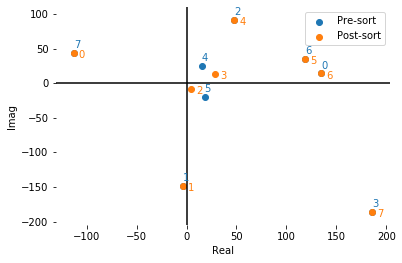

In [247]:
import matplotlib.pyplot as plt
%matplotlib inline


test = np.random.randint(-200,200,8) + 1j * np.random.randint(-200, 200, 8)
fig, ax = plt.subplots()

def label_complex(zs, color, xyoffset, label):
    ax.scatter(np.real(zs), np.imag(zs), c=color, label=label)    
    for i, z in enumerate(zs):
        ax.annotate(str(i), (np.real(z), np.imag(z)), color=color, textcoords="offset points", xytext=xyoffset)

        
label_complex(test, 'C0', (0,5), label="Pre-sort")

smooth_sorted = diff_sort(matrices, test, softmax=smoothmax)
label_complex(smooth_sorted, 'C1', (5, -5), "Post-sort")
ax.axhline(0, c='k')
ax.axvline(0, c='k')
ax.set_xlabel("Real")
ax.set_ylabel("Imag")
ax.set_frame_on(False)
ax.legend()



# Relaxed sorting
We can define a slighly modified function which interpolates between `softmax(a,b)` and `mean(a,b)`. The result is a sorting function that can be relaxed from sorting to averaging. The $\alpha$ parameter of `smoothmax` also allows relaxation to the mean, though with different scaling.

In [258]:

# Differentiable smoothed sorting 
test = np.random.randint(-200,200,8)

print("Exact sorting          ", neat_vec(diff_sort(matrices, test, np.maximum)))
print()

for smooth in np.linspace(0, 1, 8):    
    print(f"Softmax.   smooth={smooth:.2f} ", neat_vec(diff_sort(matrices, test, lambda a,b:softmax_smooth(a,b,smooth=smooth))))
    # smoothmax's alpha is the inverse of diff_bisort_smooth
    print(f"Smoothmax. α={1-smooth:.2f}      ", neat_vec(diff_sort(matrices, test, lambda a,b:smoothmax(a,b, alpha=1-smooth))))
    print()
    
print(f"Mean {np.mean(test):.2f}")
print()

Exact sorting           -154.00	-152.00	-133.00	-74.00	-66.00	-38.00	 53.00	195.00

Softmax.   smooth=0.00  -154.13	-151.87	-133.00	-74.00	-66.00	-38.00	 53.00	195.00
Smoothmax. α=1.00       -153.76	-152.24	-133.00	-74.00	-66.00	-38.00	 53.00	195.00

Softmax.   smooth=0.14  -115.62	-113.26	-105.28	-83.37	-67.49	-21.25	 29.14	108.13
Smoothmax. α=0.86       -153.69	-152.31	-133.00	-73.99	-66.01	-38.00	 53.00	195.00

Softmax.   smooth=0.29  -94.82	-93.07	-85.21	-82.17	-53.50	-17.36	  7.81	 49.34
Smoothmax. α=0.71       -153.61	-152.39	-133.00	-73.97	-66.03	-38.00	 53.00	195.00

Softmax.   smooth=0.43  -82.04	-79.39	-80.95	-78.13	-34.49	-18.04	 -7.18	 11.21
Smoothmax. α=0.57       -153.52	-152.48	-133.00	-73.92	-66.08	-38.00	 53.00	195.00

Softmax.   smooth=0.57  -72.59	-71.06	-71.82	-70.28	-28.40	-22.82	-19.07	-12.95
Smoothmax. α=0.43       -153.40	-152.59	-133.01	-73.75	-66.25	-38.00	 53.00	195.00

Softmax.   smooth=0.71  -63.24	-62.76	-62.77	-62.28	-30.76	-29.85	-29.15	-28.18
Smoothmax.

## Derivatives of the sorting process
Now we can take the derivatives of the sorting networks.

In [262]:
from autograd import jacobian

matrices = bitonic_matrices(16)
test = np.random.randint(-200,200,16)
# show that we can take the derivative
jac_sort = jacobian(diff_sort, argnum=1)
jac_sort(matrices, test, softmax=lambda a,b:softmax_smooth(a,b,0.05)) # slight relaxation

array([[0.78, 0.06, 0.02, 0.02, 0.02, 0.  , 0.  , 0.02, 0.01, 0.02, 0.  ,
        0.  , 0.01, 0.02, 0.01, 0.  ],
       [0.02, 0.  , 0.02, 0.  , 0.  , 0.02, 0.  , 0.  , 0.02, 0.02, 0.  ,
        0.02, 0.02, 0.78, 0.04, 0.02],
       [0.02, 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.02, 0.02, 0.61, 0.02,
        0.02, 0.02, 0.03, 0.21, 0.01],
       [0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.01, 0.21, 0.02,
        0.03, 0.02, 0.04, 0.61, 0.02],
       [0.06, 0.78, 0.  , 0.04, 0.  , 0.04, 0.02, 0.  , 0.01, 0.01, 0.  ,
        0.  , 0.01, 0.  , 0.02, 0.  ],
       [0.02, 0.04, 0.04, 0.78, 0.04, 0.02, 0.  , 0.  , 0.  , 0.02, 0.  ,
        0.  , 0.  , 0.  , 0.01, 0.02],
       [0.  , 0.04, 0.02, 0.02, 0.06, 0.78, 0.  , 0.02, 0.  , 0.  , 0.02,
        0.  , 0.  , 0.02, 0.  , 0.  ],
       [0.02, 0.  , 0.  , 0.04, 0.78, 0.06, 0.04, 0.02, 0.  , 0.  , 0.  ,
        0.02, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.02, 0.03, 0.03, 0.04,
        0.78, 0.01, 0.

In [263]:
# the same, but using smoothmax
print(neat_vec(diff_sort(matrices, test, smoothmax)))
jac_sort(matrices, test,  lambda a,b:smoothmax(a,b,alpha=0.5))

-144.00	-92.00	-76.97	-71.03	-40.00	-27.00	-12.00	 27.00	 50.00	102.00	115.05	120.95	131.00	162.00	195.31	197.69


array([[ 1.  , -0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.  ,
         0.  ,  0.  , -0.  , -0.  , -0.  ,  0.  ,  0.  ],
       [-0.  ,  0.  , -0.  , -0.  ,  0.  , -0.  , -0.  ,  0.  , -0.  ,
        -0.  , -0.  , -0.  , -0.  ,  1.  , -0.  , -0.  ],
       [-0.  ,  0.  ,  0.  , -0.  ,  0.  , -0.  ,  0.  , -0.  , -0.  ,
         1.2 , -0.  , -0.  ,  0.  , -0.  , -0.2 , -0.  ],
       [ 0.  , -0.  , -0.  ,  0.  , -0.  ,  0.  ,  0.  , -0.  ,  0.  ,
        -0.2 , -0.  , -0.  ,  0.  , -0.  ,  1.2 , -0.  ],
       [-0.  ,  1.02,  0.  , -0.02, -0.  ,  0.  ,  0.  , -0.  , -0.  ,
         0.  , -0.  , -0.  ,  0.  ,  0.  , -0.  ,  0.  ],
       [ 0.  , -0.02,  0.  ,  1.02,  0.  , -0.  , -0.  ,  0.  ,  0.  ,
        -0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.  , -0.  , -0.  ,  1.  , -0.  ,  0.  ,  0.  ,
        -0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  , -0.  ],
       [-0.  ,  0.  ,  0.  ,  0.  ,  1.  , -0.  , -0.  ,  0.  , -0.  ,
         0.  ,  0.  , -0. 

## Woven form
We can "weave" the four matrices `l, r, l_inv, r_inv` into two matrices for fewer matrix multiplies (but the same number of total elementwise operations) at the cost of having to split and join the matrices at each layer.

In [267]:
from differentiable_sorting import bitonic_woven_matrices, diff_sort_weave
test = np.random.randint(-200,200,8)
woven_matrices = bitonic_woven_matrices(8)
matrices = bitonic_matrices(8)

print("Exact sorting      ", neat_vec(diff_sort(matrices, test, np.maximum)))
print(f"Diff. (std.)       ", neat_vec(diff_sort(matrices, test, smoothmax)))
print(f"Diff. (woven)      ", neat_vec(diff_sort_weave(woven_matrices, test, smoothmax)))
        

Exact sorting       -167.00	-105.00	-57.00	124.00	153.00	177.00	182.00	197.00
Diff. (std.)        -167.00	-105.00	-57.00	124.00	153.00	177.03	181.97	197.00
Diff. (woven)       -167.00	-105.00	-57.00	124.00	153.00	177.03	181.97	197.00


## Differentiable ranking / argsort
We can use a differentiable similarity measure between the input and output of the vector, e.g. an RBF kernel. We can use this to generate a normalised similarity matrix and apply this to a vector `[1, 2, 3, ..., n]`. This gives a differentiable ranking function.

As `sigma` gets larger, the result converges to giving all values the mean rank; as it goes to zero the result converges to the true rank.

In [269]:
from differentiable_sorting import order_matrix, diff_argsort

In [270]:
matrices = bitonic_matrices(8)

In [271]:
x = [5.0, -1.0, 9.5, 13.2, 16.2, 10.5, 42.0, 18.0]


print("x            ", neat_vec(x))
# show argsort
ranks = diff_argsort(matrices, x, sigma=0.5)
print("diff_argsort ", neat_vec(ranks))
print("exact argsort",neat_vec(np.argsort(ranks)))

x               5.00	 -1.00	  9.50	 13.20	 16.20	 10.50	 42.00	 18.00
diff_argsort    1.00	  0.00	  2.05	  4.00	  5.00	  2.97	  7.00	  6.00
exact argsort   1.00	  0.00	  2.00	  5.00	  3.00	  4.00	  7.00	  6.00


In [272]:
# we now have differentiable argmax and argmin by indexing the rank vector
print(np.argmin(x), int(ranks[0]+0.5))
print(np.argmax(x), int(ranks[-1]+0.5))

1 1
6 6


## Smoothing ranks
We can again relax argsort back to the mean rank:

In [273]:
print("Smoothed ranks")
test = x
for sigma in [0.1, 1, 10, 100, 1000]:     
    ranks = diff_argsort(matrices, test, sigma=sigma) 
    print(f"sigma={sigma:7.1f}  |", neat_vec(ranks))

Smoothed ranks
sigma=    0.1  |   1.00	  0.00	  2.00	  4.00	  5.00	  3.00	  7.00	  6.00
sigma=    1.0  |   1.00	  0.00	  2.33	  3.97	  5.12	  2.73	  7.00	  5.85
sigma=   10.0  |   2.55	  1.92	  3.01	  3.38	  3.65	  3.11	  6.79	  3.82
sigma=  100.0  |   3.47	  3.45	  3.48	  3.49	  3.49	  3.48	  3.56	  3.50
sigma= 1000.0  |   3.50	  3.50	  3.50	  3.50	  3.50	  3.50	  3.50	  3.50



### Differentiable ranking function

In [284]:
np.set_printoptions(precision=3)
jac_rank = jacobian(diff_argsort, argnum=1)


In [285]:
matrices = bitonic_matrices(8)

x = [1, 2, 3, 4, 8, 7, 6, 4]
ranks = diff_argsort(matrices, x, sigma=1.0)
print("diff_argsort", neat_vec(ranks))
print("argsort     ", neat_vec(np.argsort(ranks)))

print("Jacobian of diff_argsort(x)")
print(jac_rank(matrices, np.array(x), 1.0))

diff_argsort   0.79	  1.49	  2.25	  3.21	  6.38	  5.67	  5.05	  3.21
argsort        0.00	  1.00	  2.00	  3.00	  7.00	  6.00	  5.00	  4.00
Jacobian of diff_argsort(x)
[[ 0.59  -0.186 -0.157 -0.12  -0.005 -0.009 -0.028 -0.084]
 [-0.131  0.506 -0.105 -0.104 -0.01  -0.019 -0.042 -0.094]
 [-0.136 -0.155  0.794 -0.171 -0.029 -0.049 -0.095 -0.159]
 [-0.102 -0.13  -0.142  0.714 -0.044 -0.069 -0.11  -0.117]
 [-0.005 -0.01  -0.029 -0.049  0.547 -0.199 -0.178 -0.077]
 [-0.009 -0.016 -0.038 -0.059 -0.139  0.453 -0.117 -0.076]
 [-0.031 -0.052 -0.096 -0.127 -0.119 -0.135  0.696 -0.136]
 [-0.102 -0.13  -0.142 -0.135 -0.044 -0.069 -0.11   0.732]]


In [288]:
matrices = bitonic_matrices(8)
from autograd import grad

# which elements cause the biggest change in ranking if adjusted?
# we can compute this directly:
x = [41, 2, 30, 40, 50, 60, 70, 190]

# approximate change in rank as first moment of ranks
rank_change = lambda x: np.sum((diff_argsort(matrices, x, sigma=1.0)* np.arange(1,9)))
grad_rank_change = grad(rank_change)
print("x        ", neat_vec(x))
print("d_rank/dx", neat_vec(grad_rank_change(np.array(x))))



x          41.00	  2.00	 30.00	 40.00	 50.00	 60.00	 70.00	190.00
d_rank/dx  -0.68	 -0.00	 -0.00	  0.68	 -0.00	 -0.00	 -0.00	  0.00


# PyTorch example
We can verify that this is both parallelisable on the GPU and fully differentiable.

In [289]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda:0


In [290]:
from differentiable_sorting_torch import softmax, diff_argsort
from differentiable_sorting import diff_sort
matrices = bitonic_matrices(32)
torch_matrices = [[torch.from_numpy(matrix).float().to(device) for matrix in matrix_set] for matrix_set in matrices]


In [291]:
test_input = np.random.normal(0, 5, 32)
var_test_input = Variable(torch.from_numpy(test_input).float().to(device),
                          requires_grad=True)

result = diff_sort(torch_matrices, var_test_input, softmax=softmax)

# compute the Jacobian of the sorting function, to show we can differentiate through the
# sorting function
jac = []
for i in range(len(result)):
    jac.append(
        torch.autograd.grad(result[i], var_test_input, retain_graph=True)[0])

# 32 x 32 jacobian of the sorting matrix
print(torch.stack(jac))

tensor([[1.4299e-04, 3.3184e-01, 5.7347e-01,  ..., 1.4077e-05, 3.8444e-06,
         1.4776e-05],
        [2.3192e-04, 3.8678e-01, 2.7400e-01,  ..., 7.5256e-05, 2.0765e-05,
         7.9379e-05],
        [7.2470e-04, 1.1587e-01, 6.4348e-02,  ..., 1.4686e-04, 4.0170e-05,
         1.5492e-04],
        ...,
        [2.5691e-04, 6.5797e-08, 2.0994e-08,  ..., 4.2036e-03, 1.0674e-02,
         3.9539e-03],
        [4.0054e-05, 9.2322e-09, 2.9685e-09,  ..., 8.8930e-04, 2.1155e-03,
         7.8699e-04],
        [9.6560e-06, 2.8358e-09, 9.2318e-10,  ..., 9.7316e-05, 2.5036e-04,
         8.9004e-05]], device='cuda:0')


In [292]:
result = diff_argsort(torch_matrices, var_test_input)
print(result)


tensor([15.0000,  1.0000,  0.0000,  8.0000, 31.0000, 12.0000, 15.0000,  9.9032,
        15.0000, 21.0033, 28.0074,  8.0000, 23.0006, 25.1560, 30.0000,  3.0000,
        12.0000, 15.0004, 15.0000,  9.3927, 25.8638, 25.9300, 10.4456, 28.0000,
         4.0006,  5.0043,  3.2523, 13.4567, 17.3526, 19.2498, 23.9960, 19.0000],
       device='cuda:0', grad_fn=<MvBackward>)
